In [ ]:
hyperparameters = {
    "learning_rate": 1e-4,
    "batch_size": 64,
    "embed_dim": 256,
    "num_heads": 4,
    "num_layers": 2,
    "dropout": 0.1,
    "ff_dim": 1024,
    "epochs": 300,
    "num_warmup_steps": 500,
    "weight_decay": 1e-4,
    "k-mers": 3,
    "max_len": 199
}

info = {
    "dataset_size": "50K",
    "SMOTE": {
        "isSmote": True,
        0: 15000,
        3: 15000,
        4: 15000
    },
    "precision": "FP16",
    "dir_name": "Mutation Model",
    "run": "Fifteenth Run",
    "loss": {
        "type": "Cross Entropy Loss",
        "alpha": 0.75, # Removed
        "gamma": 2
    },
    "optimizer": "Adam",
    "is_pre_training": False
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

data_path = f"/content/drive/MyDrive/dataset/{info['dataset_size']}.csv"

data = pd.read_csv(data_path)
data.shape

(50000, 10)

In [4]:
data['label'].value_counts()

,count
label,
2,28892
1,15847
0,2911
4,1223
3,1127


In [5]:
y = data['label']

In [6]:
import pickle

def get_codon(seq, k=hyperparameters['k-mers']):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

vocab = {}

for seq in data['sequence']:
    for codons in get_codon(seq.lower()):
        if codons not in vocab:
            vocab[codons] = len(vocab)
        else:
            continue

with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

def get_tensor(text):
    return [vocab[codons.lower()] for codons in get_codon(text)]

In [7]:
import torch
tokenized_sequences = [(torch.tensor(get_tensor(sq), dtype=torch.long)) for sq in data['sequence']]

In [8]:
from imblearn.over_sampling import SMOTE
import numpy as np

smote = SMOTE(sampling_strategy = {0:15000, 3:15000, 4:15000}, random_state=42)

In [9]:
x_resampled, y_resampled = smote.fit_resample(tokenized_sequences, y)

In [31]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
  def __init__(self, x, y):
    self.x_frame = x
    self.y_frame = y

  def __len__(self):
    return len(self.x_frame)

  def __getitem__(self, index):
    x = torch.tensor(self.x_frame[index], dtype=torch.long)
    y = torch.tensor(self.y_frame[index], dtype=torch.long)
    return x, y

In [32]:
dataset = CustomDataset(x_resampled, y_resampled)

In [33]:
y_resampled.value_counts()

,count
label,
2,28892
1,15847
0,15000
3,15000
4,15000


In [34]:
dataset = CustomDataset(x_resampled, y_resampled)

In [35]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [36]:
train_loader = DataLoader(
    train_dataset,
    batch_size=hyperparameters['batch_size'],
    shuffle=True
)

test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'])

In [37]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp((torch.arange(0, embed_dim, 2)) * (-math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class Transformer(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=6, ff_dim=2048, dropout=0.1, vocab_size=10000, max_len=5000):
        super(Transformer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_encoding = PositionalEncoding(embed_dim=embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )

        self.y_labels_out = nn.Linear(embed_dim, 5)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.position_encoding(x)

        x = self.encoder(x)
        x = x.mean(dim=1)

        y_label_out = self.y_labels_out(x)
        return y_label_out

In [38]:
model = Transformer(
    embed_dim=hyperparameters['embed_dim'],
    num_heads=hyperparameters['num_heads'],
    num_layers=hyperparameters['num_layers'],
    ff_dim=hyperparameters['ff_dim'],
    dropout=hyperparameters['dropout'],
    vocab_size=len(vocab),
    max_len=hyperparameters['max_len']
)

In [39]:
if info['is_pre_training']:
    checkpoint = torch.load(f"/content/drive/MyDrive/{info['dir_name']}/modelThirteenth Run_epoch_60.pth")

    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Transformer(
  (embeddings): Embedding(64, 256)
  (position_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (y_labels_out): Linear(in_features=256, out_features=5, bias=True)
)

In [41]:
device

device(type='cuda')

In [42]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 1597189


In [43]:
# import numpy as np

# def get_cb_weights(labels, num_classes, beta=0.9999):
#     labels = np.array(labels)
#     class_counts = np.bincount(labels, minlength=num_classes)

#     effective_num = 1.0 - np.power(beta, class_counts)
#     effective_num = np.where(effective_num == 0, 1e-8, effective_num)

#     weights = (1.0 - beta) / effective_num
#     weights = weights / np.sum(weights) * num_classes

#     return torch.tensor(weights, dtype=torch.float32)

# labels = data['label'].values
# num_classes = 5

# cb_weights = get_cb_weights(labels, num_classes, beta=0.9999).to(device)

# print("Class-Balanced Weights:", cb_weights)

In [44]:
from transformers import get_linear_schedule_with_warmup

# ce = nn.CrossEntropyLoss(weight=cb_weights)
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=hyperparameters["weight_decay"])
scaler = torch.cuda.amp.GradScaler()

if info['is_pre_training']:
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Optimizer loaded")

num_training_steps = len(train_loader) * hyperparameters['epochs']
num_warmup_steps = hyperparameters["num_warmup_steps"]

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

/tmp/ipython-input-1806760960.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [45]:
def train32(model, loader, ce, optimizer):
    model.train()

    running_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = ce(output, y)

        prediction = torch.argmax(output, dim=1)
        correct += (prediction == y).sum().item()
        total += len(x)

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * len(x)

    accuracy = correct / total

    return (
        running_loss / len(loader.dataset),
        accuracy
    )

def train16(model, loader, ce, optimizer, scaler, scheduler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(dtype=torch.float16):
            output = model(x)
            loss = ce(output, y)

        prediction = torch.argmax(output, dim=1)
        correct += (prediction == y).sum().item()
        total += len(x)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        running_loss += loss.item() * len(x)

    accuracy = correct / total
    return (
        running_loss / len(loader.dataset),
        accuracy
    )

In [46]:
def validation(model, loader, ce):
    model.eval()

    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            if info['precision'] == 'FP16':
              with torch.cuda.amp.autocast(dtype=torch.float16):
                  output = model(x)
                  loss = ce(output, y)
            else:
              output = model(x)
              loss = ce(output, y)

            running_loss += loss.item() * len(x)

            prediction = torch.argmax(output, dim=1)
            correct += (prediction == y).sum().item()

            total += len(x)

    accuracy = correct / total

    return (
        running_loss / len(loader.dataset),
        accuracy
    )

In [47]:
import os

patience = 10
best_val_loss = float('inf')
counter = 0
early_stop = False

train_loss_history = []
train_acc_history = []

val_loss_history = []
val_acc_history = []

save_dir = f"/content/drive/MyDrive/{info['dir_name']}"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(hyperparameters['epochs']+1):
    if info['precision'] == 'FP16':
      current_train_loss, current_train_acc = train16(
            model,
            train_loader,
            ce,
            optimizer,
            scaler,
            scheduler
        )
    else:
      current_train_loss, current_train_acc = train32(
          model,
          train_loader,
          ce,
          optimizer
      )

    current_val_loss, current_val_acc = validation(
        model,
        test_loader,
        ce
    )

    train_loss_history.append(current_train_loss)
    train_acc_history.append(current_train_acc)

    val_loss_history.append(current_val_loss)
    val_acc_history.append(current_val_acc)

    print(f"Epoch ({epoch}/{hyperparameters['epochs']}): Train Loss = {current_train_loss:.4f}, Valitation Loss = {current_val_loss:.4f}, Train_acc = {current_train_acc:.4f}, Val_acc = {current_val_acc:.4f}")

    if epoch % 10 == 0:
      checkpoint_path = f"{save_dir}/model{info['run']}_epoch_{epoch}.pth"
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_losses': train_loss_history,
          'val_losses': val_loss_history,
          'train_acc': train_acc_history,
          'val_acc': val_acc_history
      }, checkpoint_path)
      print(f"Model saved at {checkpoint_path}")

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        counter = 0
        continue
    else:
        counter += 1
        print(f"No improvement in val loss Counter = {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            early_stop = True
            break

/tmp/ipython-input-2163399810.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):
/tmp/ipython-input-260272857.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


Epoch (0/300): Train Loss = 1.1749, Valitation Loss = 1.0913, Train_acc = 0.4446, Val_acc = 0.4706
Model saved at /content/drive/MyDrive/Mutation Model/modelFifteenth Run_epoch_0.pth
Epoch (1/300): Train Loss = 1.0706, Valitation Loss = 1.0660, Train_acc = 0.4824, Val_acc = 0.4871
Epoch (2/300): Train Loss = 1.0551, Valitation Loss = 1.0695, Train_acc = 0.4931, Val_acc = 0.4983
No improvement in val loss Counter = 1/10
Epoch (3/300): Train Loss = 1.0441, Valitation Loss = 1.0556, Train_acc = 0.5068, Val_acc = 0.4901
Epoch (4/300): Train Loss = 1.0316, Valitation Loss = 1.0471, Train_acc = 0.5168, Val_acc = 0.5126
Epoch (5/300): Train Loss = 1.0196, Valitation Loss = 1.0291, Train_acc = 0.5281, Val_acc = 0.5227
Epoch (6/300): Train Loss = 1.0090, Valitation Loss = 1.0306, Train_acc = 0.5382, Val_acc = 0.5253
No improvement in val loss Counter = 1/10
Epoch (7/300): Train Loss = 0.9962, Valitation Loss = 1.0147, Train_acc = 0.5474, Val_acc = 0.5365
Epoch (8/300): Train Loss = 0.9830, Vali

In [48]:
def get_predictions_and_labels(model, loader):
    model.eval()
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            yout = model(x)

            _, pred_mut = torch.max(yout, 1)

            all_y_true.extend(y.cpu().numpy())
            all_y_pred.extend(pred_mut.cpu().numpy())

    return (
        (all_y_true, all_y_pred)
    )

In [49]:
from sklearn.metrics import classification_report

(y_true, y_pred) = get_predictions_and_labels(model, test_loader)

print("\n" + "="*60)
print("Classification Report Summary")
print("="*60)

print("\n[1] Classification Report — Mutation Label")
print("-" * 60)
print(classification_report(y_true, y_pred))

print("="*60 + "\n")



Classification Report Summary

[1] Classification Report — Mutation Label
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.48      0.54      3065
           1       0.47      0.15      0.22      3199
           2       0.59      0.92      0.72      5685
           3       0.67      0.59      0.63      3078
           4       0.63      0.65      0.64      2921

    accuracy                           0.61     17948
   macro avg       0.60      0.56      0.55     17948
weighted avg       0.59      0.61      0.57     17948




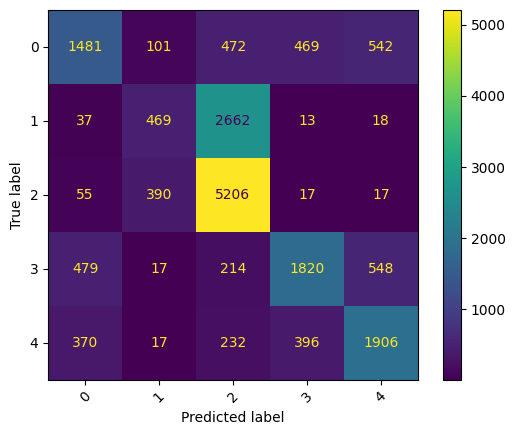

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)

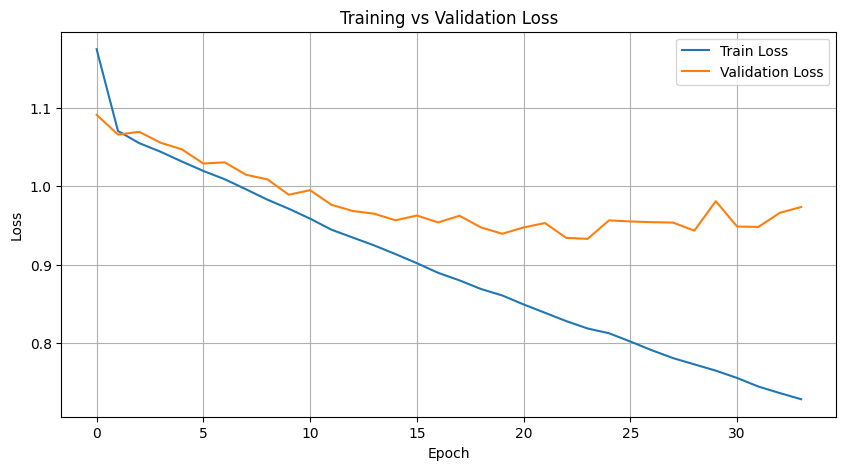

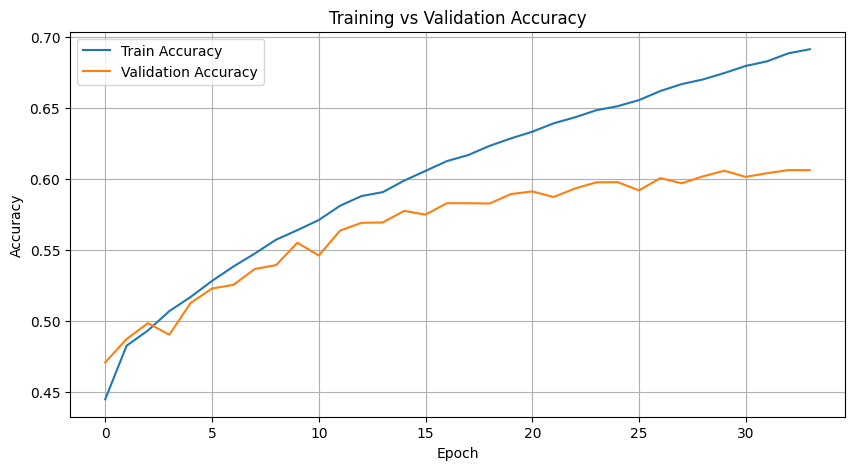

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()